In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss, PinballLoss
from model.model import LSTM, LinearNet, QuantileNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

torch.manual_seed(0)

#### Import data and set quantiles

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

## LSTM 1 layer

In [3]:
# lookback periods
slide = 8

In [4]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all = FrameTorch(data_non_spread)
# split data
frametorch_all.split_data()
# scale datag
frametorch_all.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

In [5]:
# number of inputs and outputs
n_inputs = frametorch_all.data.shape[1] - 1
n_outputs = len(quantiles)

In [6]:
# model
quantilenet_smooth = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_smooth.parameters(), lr=0.0003)
# trainer class
trainer_smooth = Trainer(quantilenet_smooth, criterion, optimizer)

#### TRAIN DE MODEL

In [55]:
quantilenet_smooth = trainer_smooth.fit(
    train_loader, val_loader, epochs=200, n_logger=10, patience=100
)

## LSTM 2 layers

In [8]:
# lookback periods
slide = 6

In [9]:
data_non_spread2 = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all2 = FrameTorch(data_non_spread2)
# split data
frametorch_all2.split_data()
# scale datag
frametorch_all2.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all2.data_to_loader(slide=slide)

In [10]:
# number of inputs and outputs
n_inputs = frametorch_all2.data.shape[1] - 1
n_outputs = len(quantiles)

In [11]:
# model
quantilenet_smooth2 = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_smooth2.parameters(), lr=0.0003)
# trainer class
trainer_smooth2 = Trainer(quantilenet_smooth2, criterion, optimizer)

#### TRAIN DE MODEL

In [49]:
quantilenet_smooth2 = trainer_smooth2.fit(
    train_loader, val_loader, epochs=2000, n_logger=10, patience=100
)

## LSTM 3 layers

In [13]:
# lookback periods
slide = 4

In [14]:
data_non_spread3 = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all3 = FrameTorch(data_non_spread3)
# split data
frametorch_all3.split_data()
# scale datag
frametorch_all3.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all3.data_to_loader(slide=slide)

In [15]:
# number of inputs and outputs
n_inputs = frametorch_all3.data.shape[1] - 1
n_outputs = len(quantiles)

In [16]:
# model
quantilenet_smooth3 = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_smooth3.parameters(), lr=0.0003)
# trainer class
trainer_smooth3 = Trainer(quantilenet_smooth3, criterion, optimizer)

#### TRAIN DE MODEL

In [46]:
quantilenet_smooth3 = trainer_smooth3.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

epoch: 0 train loss: 0.077 val loss: 0.087


## COMPARE MODELS

In [31]:
# lsmt
train_loss_lstm = pd.Series(trainer_smooth.train_losses[1:])
val_loss_lstm = pd.Series(trainer_smooth.val_losses)
# mlp
train_loss_lstm2 = pd.Series(trainer_smooth2.train_losses[1:])
val_loss_lstm2 = pd.Series(trainer_smooth2.val_losses)
# linear
train_loss_lstm3 = pd.Series(trainer_smooth3.train_losses[1:])
val_loss_lstm3 = pd.Series(trainer_smooth3.val_losses)

# aggregate
train_loss = pd.concat(
    [train_loss_lstm, train_loss_lstm2, train_loss_lstm3], 
    axis=1, 
    keys=['LSTM 1 layer', 'LSTM 2 layer', 'LSTM 3 layer']
)
validation_loss = pd.concat(
    [val_loss_lstm, val_loss_lstm2, val_loss_lstm3], 
    axis=1, 
    keys=['LSTM 1 layer', 'LSTM 2 layer', 'LSTM 3 layer']
)

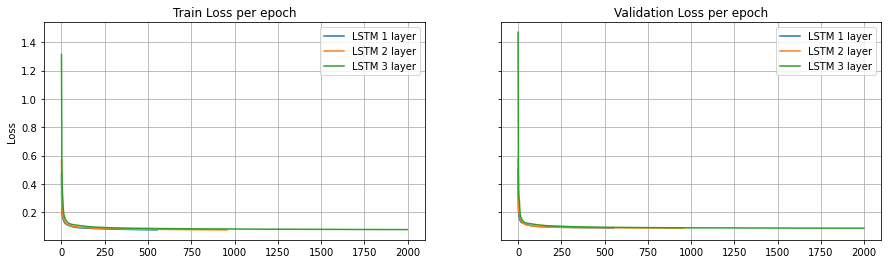

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)

train_loss.plot(ax=ax[0])
validation_loss.plot(ax=ax[1])

ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[0].grid()

ax[1].set_title('Validation Loss per epoch')
ax[1].grid()

### Predictions

In [56]:
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

# validation input and target
inputs, target_lstm = val_loader.dataset.inputs, val_loader.dataset.target
y_test_lstm = pd.Series(target_lstm.squeeze().tolist())

# quantilenet predictions
_y_pred_lstm = quantilenet_smooth(inputs)
y_pred_lstm = pd.DataFrame(_y_pred_lstm.tolist(), columns=quantiles.tolist())

In [57]:
train_loader, val_loader, test_loader = frametorch_all2.data_to_loader(slide=slide)

# validation input and target
inputs, target_lstm2 = val_loader.dataset.inputs, val_loader.dataset.target
y_test_lstm2 = pd.Series(target_lstm2.squeeze().tolist())

# quantilenet predictions
_y_pred_lstm2 = quantilenet_smooth2(inputs)
y_pred_lstm2 = pd.DataFrame(_y_pred_lstm2.tolist(), columns=quantiles.tolist())


In [58]:
train_loader, val_loader, test_loader = frametorch_all3.data_to_loader(slide=slide)

# validation input and target
inputs, target_lstm3 = val_loader.dataset.inputs, val_loader.dataset.target
y_test_lstm3 = pd.Series(target_lstm3.squeeze().tolist())

# quantilenet predictions
_y_pred_lstm3 = quantilenet_smooth3(inputs)
y_pred_lstm3 = pd.DataFrame(_y_pred_lstm3.tolist(), columns=quantiles.tolist())

## Scores

In [60]:
scores_lstm = get_scores(_y_pred_lstm, target_lstm, quantiles)
scores_lstm2 = get_scores(_y_pred_lstm2, target_lstm2, quantiles)
scores_lstm3 = get_scores(_y_pred_lstm3, target_lstm3, quantiles)

final_scores = pd.concat(
    [scores_lstm, scores_lstm2, scores_lstm3], axis=1, keys=['LSTM 8 obs', 'LSTM 6 obs', 'LSTM 4 obs']
)
final_scores

,LSTM 8 obs,LSTM 6 obs,LSTM 4 obs
QS,0.083623,0.083170,0.082223
IS,0.295596,0.293767,0.291829
Sharpnees,0.184081,0.180350,0.179683
ACE,1.689915,2.634121,1.024680


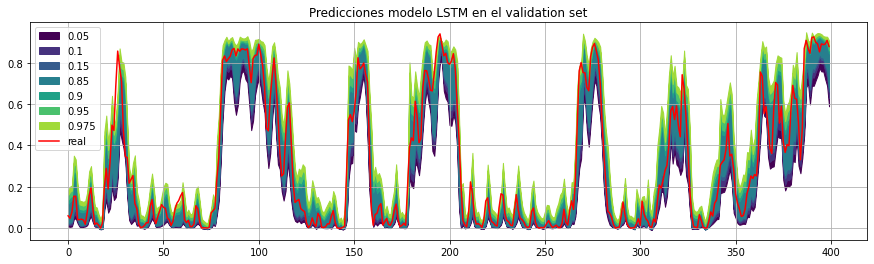

In [62]:
train_loader, val_loader, test_loader = frametorch_all3.data_to_loader(slide=slide)

# validation input and target
inputs, target_lstm3 = test_loader.dataset.inputs, test_loader.dataset.target
y_test_lstm3 = pd.Series(target_lstm3.squeeze().tolist())

# quantilenet predictions
_y_pred_lstm3 = quantilenet_smooth3(inputs)
y_pred_lstm3 = pd.DataFrame(_y_pred_lstm3.tolist(), columns=quantiles.tolist())


n_quantiles = len(quantiles)
legends = round(pd.Series(quantiles.tolist()), 3).to_list()[1:] + ['real']

viridis = cm.get_cmap('viridis', n_quantiles)
n_days_back = 400

fig, ax = plt.subplots(figsize=(15, 4))

# lstm plot
for i in range(n_quantiles-1):
    ax.fill_between(
        y_pred_lstm3.index[:n_days_back], 
        y_pred_lstm3[quantiles[i].item()][:n_days_back], 
        y_pred_lstm3[quantiles[i+1].item()][:n_days_back], 
        color=viridis.colors[i]
    )  
y_test_lstm3[:n_days_back].plot(color='red', ax=ax)
ax.set_title('Predicciones modelo LSTM en el validation set')
ax.grid()
ax.legend(legends)
plt.show()